**In this notebook we'll perform EDA and answer some questions so we have a rough idea of what to expect from our model.**

In [1]:
import pandas as pd
import json
import folium
import matplotlib.pyplot as plt
%matplotlib inline

from module2_scripts.grapher import Grapher

pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [2]:
input_df = pd.read_csv('working_datasets/df_clean_for_EDA.csv')

The above cell imports the original dataset, cleaned, into this notebook.

### In this notebook we'll explore 3 questions, all looking at trends and distributions of the housing data using a zipcodes-centric approach.

**Questions**:

1. What are the MoM average sale prices by zipcode group? What are the trends?
2. What does the distribution of total unit size (living size + lot size) look like by zipcode group?
3. Are waterfront properties generally higher priced? What are the concentrations of waterfront properties by zipcode group? 



To begin, we need to reformat out dataframe so that zipcodes are binned into their respective categories. See the 'manual_binning_config.jsonc' file in this repo for the binning configurations

In [3]:
#import bin_config from JSON and mutate dict so that each elem in value is its own key, 
#with the corresponding key as the value (i.e. keys and values are flipped using the elements in each value)
bin_config_raw = json.load(open('module2_configs/manual_binning_config.jsonc', 'rb'))
bin_config = {elem: k for k, v in bin_config_raw['zipcode'].items() for elem in v}

In [4]:
#map input zipcodes to corresponding bins
input_df['zipcode'] = input_df['zipcode'].map(lambda x: bin_config.get(x))
input_df.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_basement,yr_built,zipcode,lat,long
0,2014-10-13,221900.00,3.00,1.00,1180.00,5650.00,1.00,0.00,0.00,3,7,0,1955,D,47.51,-122.26
1,2014-12-09,538000.00,3.00,2.25,2570.00,7242.00,2.00,0.00,0.00,3,7,1,1951,A,47.72,-122.32
2,2015-02-25,180000.00,2.00,1.00,770.00,10000.00,1.00,0.00,0.00,3,6,0,1933,B,47.74,-122.23
3,2014-12-09,604000.00,4.00,3.00,1960.00,5000.00,1.00,0.00,0.00,5,7,1,1965,A,47.52,-122.39
4,2015-02-18,510000.00,3.00,2.00,1680.00,8080.00,1.00,0.00,0.00,3,8,0,1987,G,47.62,-122.05


**Question 1: What are the MoM average sale prices by zipcode group? What are the trends?**

In [5]:
df = input_df.copy()
df['month_year'] = pd.to_datetime(df['date']).dt.to_period('M')
df = df.groupby(['month_year', 'zipcode'])['price'].mean().unstack()
df.index = df.index.map(lambda x: x.to_timestamp())
df

zipcode,A,B,C,D,E,F,G,H,I
month_year,,,,,,,,,
2014-05-01,560725.40,568749.19,735738.86,299081.38,329793.13,285371.07,626438.39,301021.30,478613.41
2014-06-01,566612.72,621869.12,735672.27,302865.95,345289.99,278157.50,593721.19,332102.40,468968.75
2014-07-01,566045.88,590820.82,716891.90,312294.00,345750.22,282873.80,622227.58,317141.49,452686.94
2014-08-01,542082.36,568631.77,677965.33,308448.65,315339.20,289367.95,605855.94,325545.68,446513.42
2014-09-01,548030.08,549647.15,677655.88,303796.09,348640.21,286275.22,619854.82,342290.06,469179.10
2014-10-01,548296.26,602396.44,716973.81,295113.59,338946.56,278191.77,614645.51,306638.42,405330.48
2014-11-01,540943.52,589131.96,633694.66,300562.35,337987.94,277048.85,619089.82,310873.37,420905.52
2014-12-01,544492.21,561221.94,710215.66,317512.14,346034.51,272072.14,611936.38,297014.77,420040.91
2015-01-01,546293.94,571479.14,692764.23,295785.89,322164.80,295748.24,631768.00,300046.56,471875.70


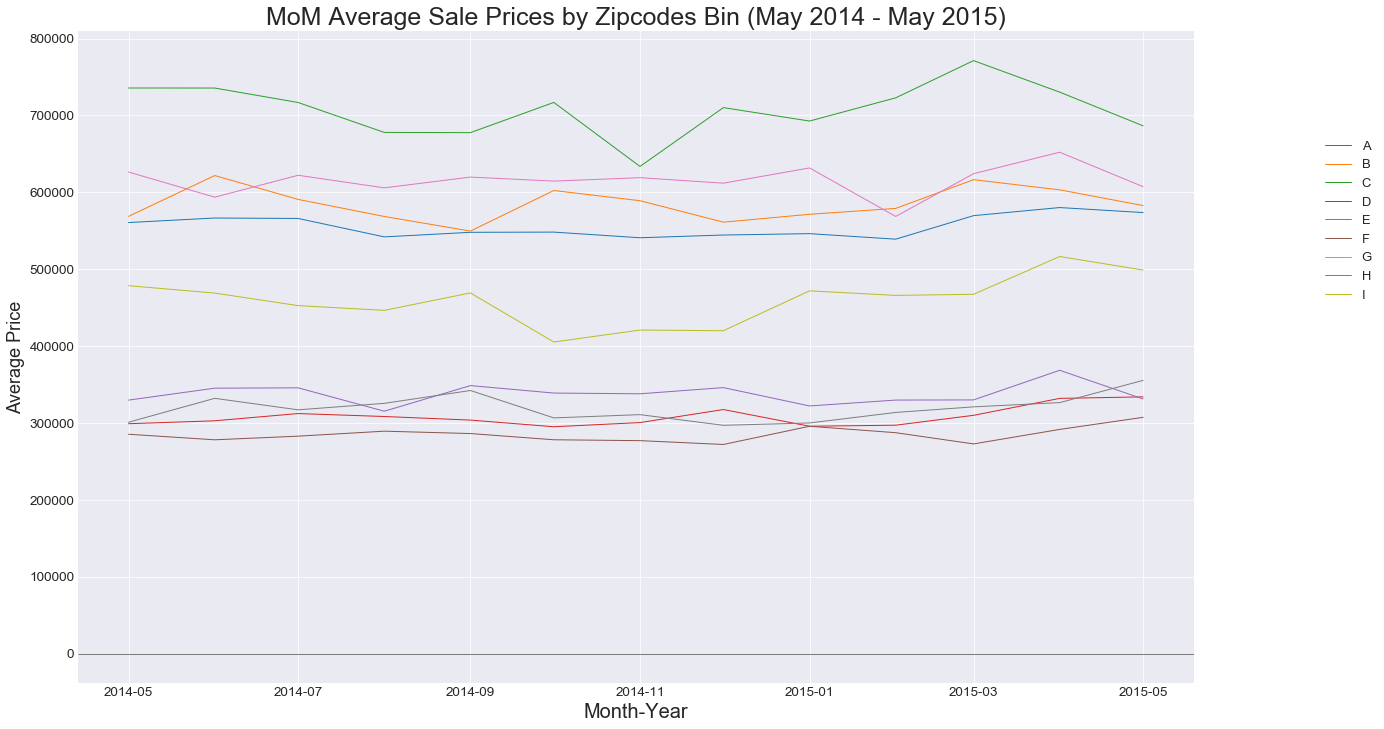

In [6]:
Grapher.plot_multiple_line_graph(
    xlabel='Month-Year',
    ylabel='Average Price', 
    title='MoM Average Sale Prices by Zipcodes Bin (May 2014 - May 2015)', 
    df=df
)

Overall, it looks like the trends are pretty flat across all the zipcode bins. We can clearly see from the df_grouped table and the graph above that the 'C' bin has the highest average sale prices of all the bins. The zipcodes in this bin might have residents with higher income per capital than other zipcodes, thus houses must be more expensive. We expect to see this reflected in the model that we build, i.e. the dummy variable for zipcodes in 'C' will have a high positive coefficient.

**Question 2: What does the distribution of total unit size (living size + lot size) look like by zipcode group?**

C:\Users\jabdullah\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


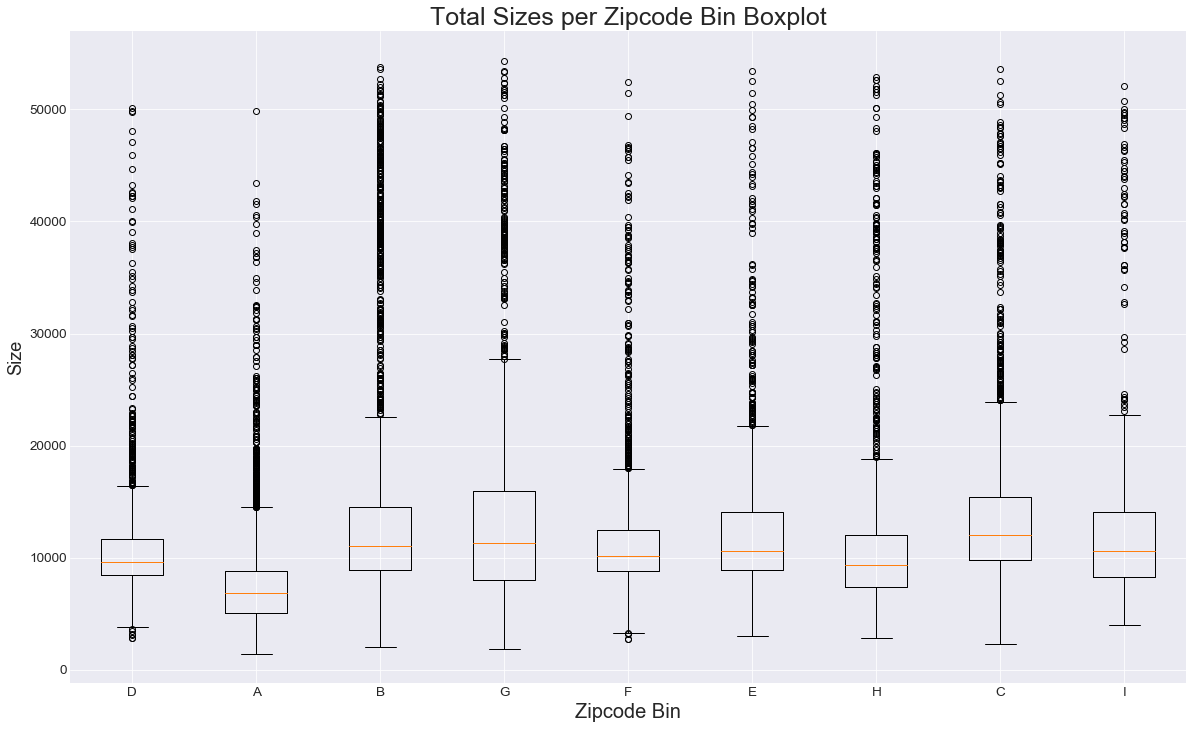

In [7]:
df = input_df.copy()
df['total_size'] = df['sqft_living'] + df['sqft_lot']
sizes_by_bin_dct = {bin_: df.loc[df['zipcode'] == bin_, 'total_size'].values.tolist() for bin_ in df['zipcode'].unique()}
Grapher.plot_boxplot(
    xlabel='Zipcode Bin', 
    ylabel='Size', 
    title='Total Sizes per Zipcode Bin Boxplot', 
    dct=sizes_by_bin_dct
)

In [8]:
df_grouped_sum = df.groupby('zipcode')[['total_size']].sum()
df_grouped_sum = df_grouped_sum.rename(columns={'total_size': 'agg_total_size'})
df_grouped_average = df.groupby('zipcode')[['total_size']].mean()
df_grouped_average = df_grouped_average.rename(columns={'total_size': 'avg_total_size'})

In [9]:
df_grouped_sum

,agg_total_size
zipcode,
A,53260261.00
B,38622482.00
C,33592653.00
D,17380006.00
E,16792637.00
F,19176893.00
G,22962699.00
H,15756609.00
I,7103005.00


In [10]:
df_grouped_average

,avg_total_size
zipcode,
A,7263.09
B,14406.00
C,13801.42
D,11041.94
E,12897.57
F,12068.53
G,14061.67
H,12377.54
I,13846.01


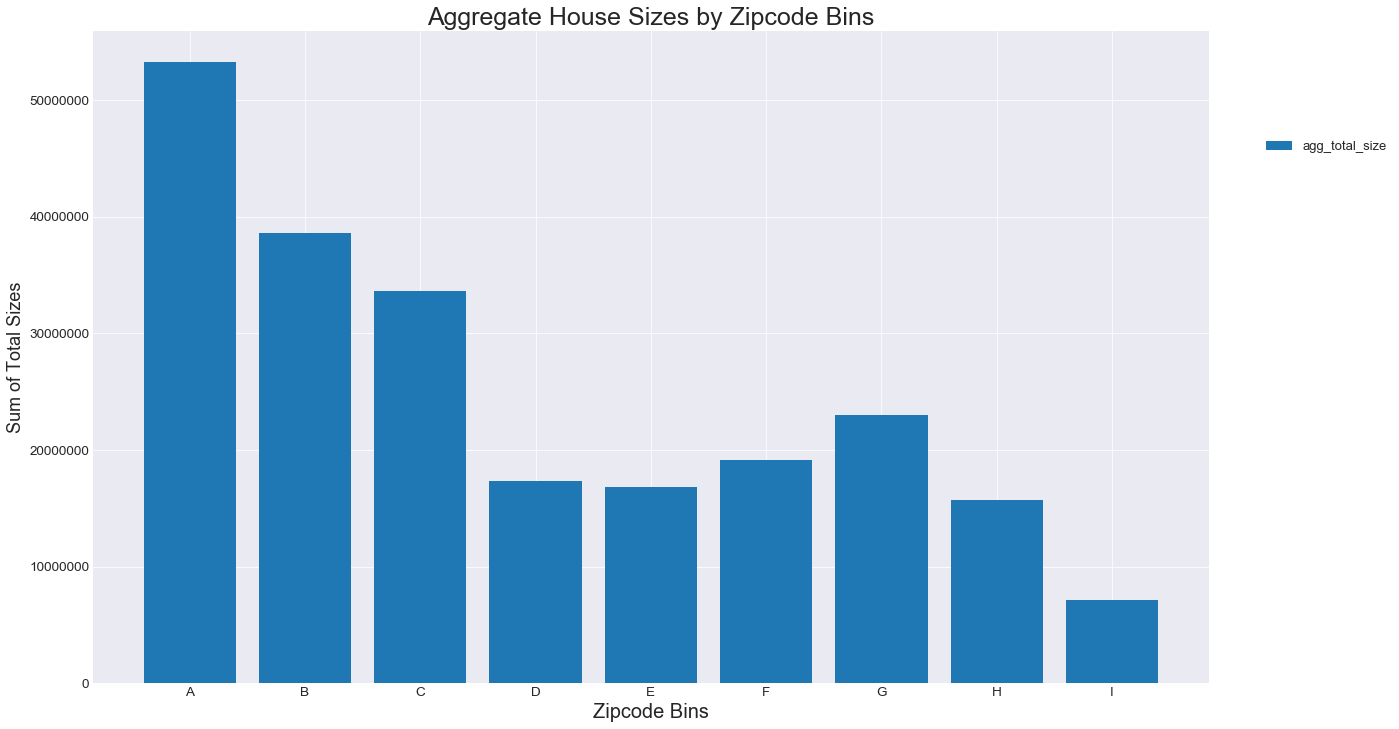

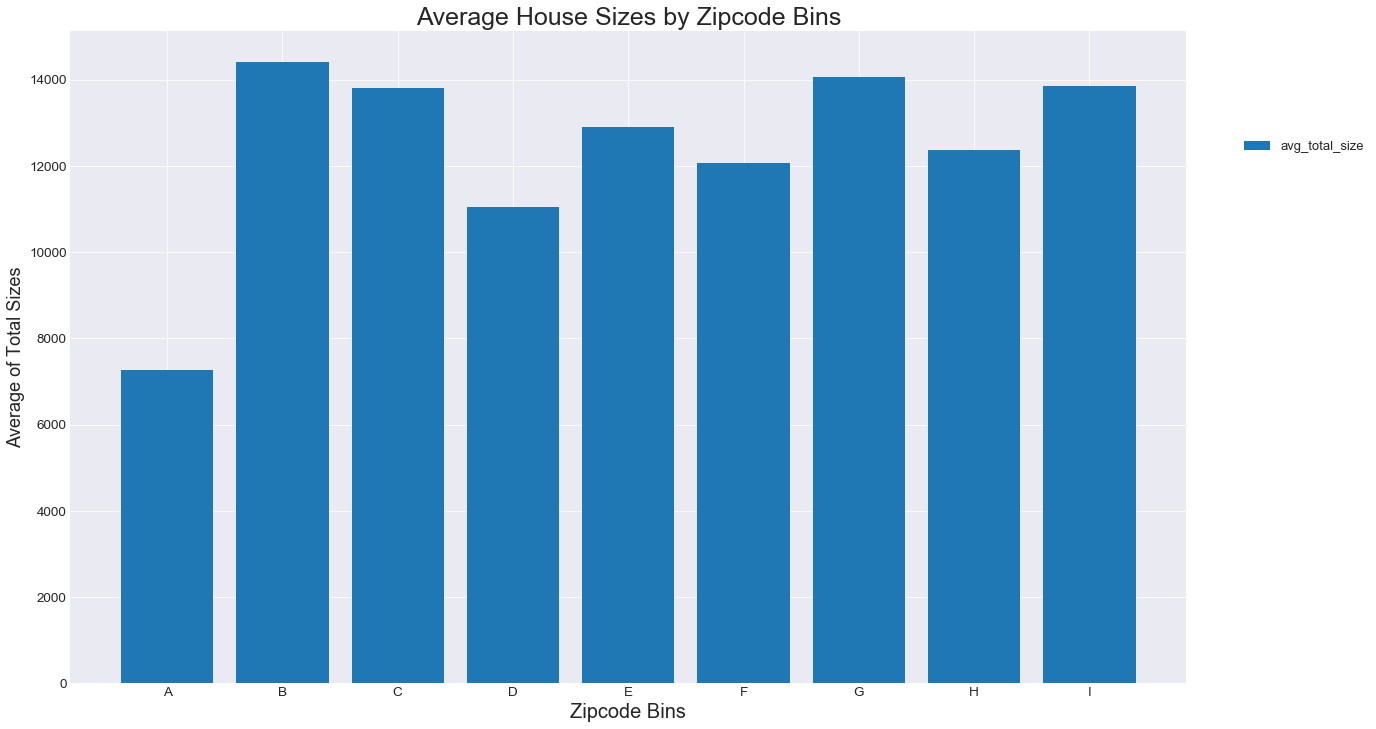

In [11]:
Grapher.plot_multiple_bar_graph(
    xlabel='Zipcode Bins',
    ylabel='Sum of Total Sizes',
    title='Aggregate House Sizes by Zipcode Bins',
    df=df_grouped_sum
)
Grapher.plot_multiple_bar_graph(
    xlabel='Zipcode Bins',
    ylabel='Average of Total Sizes',
    title='Average House Sizes by Zipcode Bins',
    df=df_grouped_average
)

Looking at the distribution of total (house + lot) sizes, we can see from the boxplot that there are many outliers on the high end/right tail of the distribution. This is expected since the minimum value of the distribution has to be 0 and the variables are continuous, and outliers are more likely to be on the right tail i.e. houses that are abnormally larger than an average house. 

The bar graphs show the aggregate sum and averages respectively of all the houses in each zipcode bin. One interesting thing to note, is that zipcode A has the largest total house size, but the smallest average size. We can conclude that zipcode bin A may have the high concentration of houses that are modestly sized. Zipcode B came in 2nd for highest aggregate sum and 1st for highest average sum. Zipcode bin C, our bin of interest in question #1, came in 3rd for highest aggregate sum, and a close 4th (but also not too far off from 2nd) in terms of highest average house sizes. This further paints the picture that zipcode C house prices are high, and house sizes are large as well. 

**Question 3: Are waterfront properties generally higher priced? What are the concentrations of waterfront properties by zipcode group?**

In [12]:
df = input_df.copy()

In [13]:
df_grouped = df.groupby('waterfront')[['price']].mean()
df_grouped

,price
waterfront,
0.00,509600.52
1.00,1144775.54


Above we clearly can see that waterfront properties are priced higher than non-waterfront properties on average in this dataset. Not surpising however, that's probably common knowledge anyways. Let's take a look at the concentratations of waterfront properties by zipcodes next.

In [14]:
df_waterfront = df[df['waterfront'] == 1].copy()
df_waterfront_count = pd.DataFrame(df_waterfront['zipcode'].value_counts())
df_waterfront_count.index.name = 'bin'
df_waterfront_count.columns = ['count']
df_waterfront_count

,count
bin,
E,40
A,17
C,11
D,9
G,9
B,5
F,1


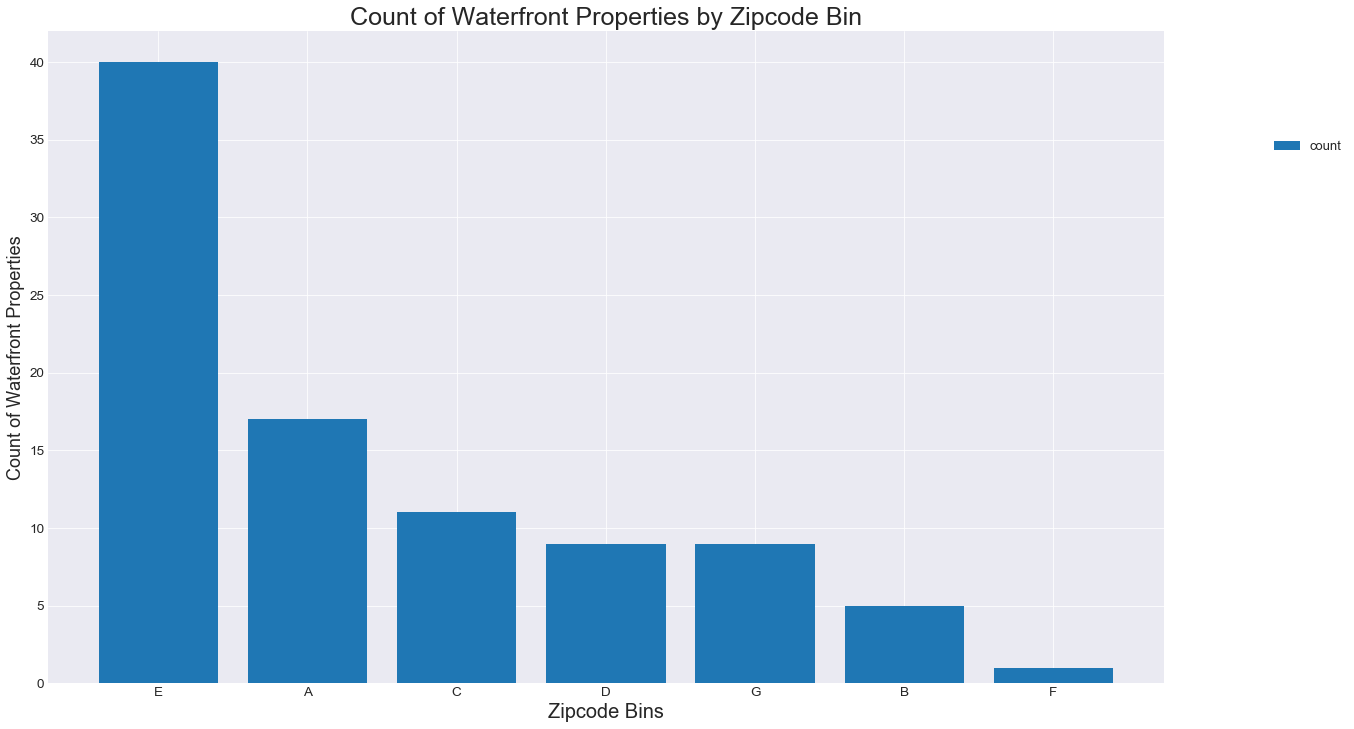

In [15]:
Grapher.plot_multiple_bar_graph(
    xlabel='Zipcode Bins',
    ylabel='Count of Waterfront Properties',
    title='Count of Waterfront Properties by Zipcode Bin',
    df=df_waterfront_count
)

We see that zipcode bin E has the highest count of waterfront properties.

As a final visualization, let's take a look at the area of zipcode bin E on an actual map.

In [16]:
#spawn the map to the average latitude and longtitude coordinates of all waterfront 
#properties in zipcode bin E, and then mark each one
df_waterfront_E = df_waterfront[df_waterfront['zipcode'] == 'E'].copy()
location = df_waterfront_E['lat'].mean(), df_waterfront_E['long'].mean()
m = folium.Map(location=location,zoom_start=15,min_zoom=5)
for i in range(0,len(df_waterfront_E)):
    folium.Marker([df_waterfront_E.iloc[i]['lat'], df_waterfront_E.iloc[i]['long']]).add_to(m)

In [17]:
m

We can see that zipcode E sort of encompasses Vashon Island, Maury Island, and some soundview properties accross the water, on the mainland. So this can serve as sort of a validation check that these data points that were tagged to zipcode E are actually waterfront properties.

**In summary, from the EDA just done, we should see in our model that the dummy variables for zipcode bin == 'C' and waterfront == 1 (or True) will reflect a positive coefficient, pushing our derived price higher.**